# **SUMMARY**
- .pt is working fine with great inference
- The quantized onnx model for this notebook is working fine with great inference
- The fucking tflite model is returning `Class confidence: 0.0016` but with great inference
- All models are saved in MLFlow
- All metrics are saved in MLFlow

## **TO DOs**
1.   Get origin code
2.   Export as tflite
3.   Benchmark tflite
4.   Validate and predict with tflite
5.   If this shit works proceed with next step else <font color="red">***FIX THIS SHIT!***</font>

6.   Create new notebook this time <font color="orange">**DO NOT OVER ENGINEER THE CODE!**</font>
7.   JUST execute the following!
      *   roboflow dataset
      *   daghub credentials
      *   mlflow logs
      *   simple error handling
      *   export to .pt, quantized .onnx, tflite


[onnx](https://docs.ultralytics.com/integrations/onnx/)

[tflite](https://docs.ultralytics.com/integrations/tflite/)

[tflite edge-tpu](https://docs.ultralytics.com/integrations/edge-tpu/#usage)

## **1. Setup and Configuration**

### **Package Installation and Imports**

In [ ]:
# Install required packages
!pip install ultralytics supervision roboflow mlflow python-dotenv onnxruntime --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 80.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 120.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 115.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7

In [ ]:
# Import necessary libraries
import os
import time
import glob
import torch
import mlflow
import tensorflow as tf
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import psutil
import datetime
import shutil
import onnxruntime as ort
import cv2
from typing import Dict, Union, Optional
from dataclasses import dataclass
from sklearn.metrics import precision_recall_curve
from ultralytics import YOLO
from IPython.display import Image as IPyImage, display
from mlflow.tracking import MlflowClient

# Set up MLflow credentials using Colab secrets
from google.colab import userdata

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


### **MLflow Setup**

In [ ]:
# User defined inputs
MLFLOW_TRACKING_URI = 'https://dagshub.com/erwincarlogonzales/defect-detection-yolov11.mlflow'
EXPERIMENT_NAME = 'object-detection-YOLO11-edge'

# Get credentials and set environment variables
try:
    os.environ.update({
        'MLFLOW_TRACKING_URI': MLFLOW_TRACKING_URI,
        'MLFLOW_TRACKING_USERNAME': userdata.get('MLFLOW_TRACKING_USERNAME'),
        'MLFLOW_TRACKING_PASSWORD': userdata.get('MLFLOW_TRACKING_PASSWORD')
    })

    # Verify MLflow connection
    mlflow.set_experiment(EXPERIMENT_NAME)
    print(f"Successfully connected to MLflow {MLFLOW_TRACKING_URI}")
    print(f"Using experiment: {EXPERIMENT_NAME}")

except Exception as error:
    if 'userdata.get' in str(error):
        raise Exception(f"Failed to get secrets from Colab: {error}")
    raise ConnectionError(f'MLflow setup failed: {error}')

2025/05/01 20:46:16 INFO mlflow.tracking.fluent: Experiment with name 'object-detection-YOLO11-edge' does not exist. Creating a new experiment.


Successfully connected to MLflow https://dagshub.com/erwincarlogonzales/defect-detection-yolov11.mlflow
Using experiment: object-detection-YOLO11-edge


### **Hardware Verification**

In [ ]:
# Check GPU availability
!nvidia-smi

Thu May  1 20:46:17 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   41C    P8             12W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### **Configuration Settings**
- Dataset URL configuration
- Model parameters = user inputs (type, epochs, image size, confidence threshold)
- Early stopping settings (patience) YOLO does not have `early_stopping` parameter

### **Model Name Generation**
- `generate_model_name()`: Creates standardized model names from configuration

In [ ]:
# Configuration
CONFIG = {
    'dataset_url': 'https://app.roboflow.com/ds/JgwZ6J3BBV?key=Q4LLoOljfi',
    'model_type': 'yolo11n.pt',
    'epochs': 50,
    'image_size': 640,
    'conf_threshold': 0.50,
    'patience': 5
}

def generate_model_name(config: Dict[str, Union[str, int, float]], separator: str = "-") -> str:
# Validate epochs value
    if not isinstance(config.get('epochs'), int) or config['epochs'] <= 0:
        raise ValueError("epochs must be a positive integer")

    # Get model type from config, default to empty string
    model_type = config.get('model_type', '')

    # Validate model type
    if not model_type or '.' not in model_type:
        raise ValueError("model_type must be a non-empty string with a file extension")

    # Extract model type without extension
    model_type = model_type.split('.')[0]

    # Get confidence threshold from config, default to 0.25
    conf_threshold = config.get('conf_threshold', 0.25)

    # Convert confidence threshold to integer percentage
    conf_value = str(int(conf_threshold * 100))  # Convert 0.25 to "25"

    # Construct and return the model name
    return f"{model_type}{separator}{config['epochs']}{separator}{conf_value}"

### **Directory Setup**
- Working directory configuration
- Dataset directory creation and management

In [ ]:
# Set up working directory and dataset
HOME = os.getcwd()
print(f'Working Directory: {HOME}')

# Create dataset directory
!mkdir {HOME}/datasets
%cd {HOME}/datasets

Working Directory: /content
/content/datasets


In [ ]:
# Download and extract Roboflow dataset
%%time
!curl -L '{CONFIG['dataset_url']}' > roboflow.zip 2>/dev/null
!unzip -q roboflow.zip
!rm roboflow.zip

# Return to home directory
%cd {HOME}

/content
CPU times: user 14.7 ms, sys: 4.7 ms, total: 19.4 ms
Wall time: 2.41 s


In [ ]:
# Utility Function
def get_latest_train_dir(home_dir):
    # Use glob to find all directories matching the pattern 'runs/detect/train*'
    train_dirs = glob.glob(f'{home_dir}/runs/detect/train*')

    # If no training directories are found, raise an exception
    if not train_dirs:
        raise FileNotFoundError("No training directories found")

    # Return the directory with the latest modification time
    return max(train_dirs, key=os.path.getmtime)

### **Visualization Functions**
- `plot_confusion_matrix_heatmap()`: Creates confusion matrix visualizations
- `plot_training_metrics()`: Generates training metrics plots
- `extract_yolo_metrics()`: Extracts final metrics from YOLO results

In [ ]:
# Visualization Functions
def plot_confusion_matrix_heatmap(confusion_matrix, labels=['No Defect', 'Defect']):

    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix Heatmap')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    heatmap_path = f'{HOME}/confusion_matrix_heatmap.png'
    plt.savefig(heatmap_path)
    plt.close()

    return heatmap_path

def plot_training_metrics(results_file):

    # Load results from YOLO's CSV file
    results = pd.read_csv(results_file)

    plt.figure(figsize=(15, 8))
    metrics_to_plot = {
        'metrics/precision(B)': 'Precision',
        'metrics/recall(B)': 'Recall',
        'metrics/mAP50(B)': 'mAP@0.5',
        'metrics/mAP50-95(B)': 'mAP@0.5:0.95'
    }

    for col, label in metrics_to_plot.items():

        if col in results.columns:
            plt.plot(results.index, results[col], label=label, marker='o')

    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.title('Training Metrics Over Time')
    plt.grid(True)
    plt.legend()

    metrics_path = f'{HOME}/training_metrics.png'
    plt.savefig(metrics_path)
    plt.close()

    return metrics_path

def extract_yolo_metrics(results_file):

    # Load results from the CSV file into a pandas DataFrame
    results = pd.read_csv(results_file)

    # Get the last row of the DataFrame, which represents the final epoch's results
    final_epoch = results.iloc[-1]

    # Create a dictionary to store the final metrics
    # Access specific columns from the 'final_epoch' Series using column names
    return {
        'final_precision': final_epoch['metrics/precision(B)'],
        'final_recall': final_epoch['metrics/recall(B)'],
        'final_mAP50': final_epoch['metrics/mAP50(B)'],
        'final_mAP50-95': final_epoch['metrics/mAP50-95(B)']
    }

### **Training Support Functions**
- `log_training_params()`: Logs model parameters to MLflow
- `train_yolo_model()`: Handles YOLO model training
- `get_latest_train_dir()`: Retrieves most recent training directory
- `process_confusion_matrix()`: Processes and logs confusion matrix data
- `process_training_metrics()`: Processes and logs training metrics
- `log_yolo_artifacts()`: Logs YOLO artifacts to MLflow
- `display_training_results()`: Shows training visualizations
- `display_predictions()`: Displays model predictions

In [ ]:
# Training and MLFlow functions
def log_training_params(config):

    # Log key parameters to MLflow for tracking and reproducibility
    mlflow.log_params({
        'model_type': config['model_type'],         # The type of YOLO model used
        'epochs': config['epochs'],                 # Number of training epochs
        'image_size': config['image_size'],         # Image size used for training
        'conf_threshold': config['conf_threshold']  # Confidence threshold for detections
    })

def train_yolo_model(config):

    start_time = time.time()

    # Disable MLflow callback before training to avoid conflicts
    from ultralytics.utils.callbacks.mlflow import callbacks as mlflow_callbacks
    mlflow_callbacks.clear()

    # Set training batch size
    # batch_size = 16  # For T4
    batch_size = 32  # For L4
    # batch_size = 64  # For A100 - can go much higher

    # Start YOLO training using the command-line interface
    !yolo task=detect mode=train \
        model={config['model_type']} \
        data=/content/datasets/data.yaml \
        epochs={config['epochs']} \
        imgsz={config['image_size']} \
        patience={config['patience']} \
        batch={batch_size} \
        device=0 \
        half=True \
        plots=True

    return time.time() - start_time

def get_latest_train_dir(home_dir):

    # Use glob to find all directories matching the pattern 'runs/detect/train*'
    train_dirs = glob.glob(f'{home_dir}/runs/detect/train*')

    # If no training directories are found, raise an exception
    if not train_dirs:
        raise FileNotFoundError("No training directories found")

    # Return the directory with the latest modification time
    # (using os.path.getmtime as the key for the max function)
    return max(train_dirs, key=os.path.getmtime)

def process_confusion_matrix(home_dir):

    # Get the most recent training directory
    latest_dir = get_latest_train_dir(home_dir)

    # Construct the path to the confusion matrix file within the latest training directory
    confusion_matrix_path = f'{latest_dir}/confusion_matrix.npy'

    # Check if the confusion matrix file exists
    if not os.path.exists(confusion_matrix_path):
        print(f'WARNING: Confusion matrix not found at: {confusion_matrix_path}')
        return None  # Return None if the file is not found

    # Load the confusion matrix from the file
    confusion_matrix = np.load(confusion_matrix_path)

    # Create and log a heatmap visualization of the confusion matrix
    heatmap_path = plot_confusion_matrix_heatmap(confusion_matrix)
    mlflow.log_artifact(heatmap_path, 'visualizations')

    # Calculate and log confusion matrix metrics (TP, TN, FP, FN)
    tn, fp, fn, tp = confusion_matrix.ravel()  # Flatten the matrix
    metrics = {
        'true_positives': tp,
        'true_negatives': tn,
        'false_positives': fp,
        'false_negatives': fn
    }
    mlflow.log_metrics(metrics)

    # Return the confusion matrix
    return confusion_matrix

def process_training_metrics(home_dir):

    # Get the most recent training directory
    latest_dir = get_latest_train_dir(home_dir)

    # Construct the path to the results CSV file within the latest training directory
    results_file = f'{latest_dir}/results.csv'

    # Check if the results file exists
    if not os.path.exists(results_file):
        print(f'WARNING: Results file not found at: {results_file}')
        return  # Return early if the file is not found

    # Create and log a plot of the training metrics over time
    metrics_path = plot_training_metrics(results_file)
    mlflow.log_artifact(metrics_path, 'visualizations')

    # Extract and log final YOLO metrics (precision, recall, mAP)
    yolo_metrics = extract_yolo_metrics(results_file)
    mlflow.log_metrics(yolo_metrics)

def log_yolo_artifacts(home_dir):

    # Get the most recent training directory
    latest_dir = get_latest_train_dir(home_dir)
    print(f"Logging artifacts from: {latest_dir}")

    # Define a dictionary mapping artifact names to their file paths
    artifact_paths = {
        'confusion_matrix': f'{latest_dir}/confusion_matrix.png',
        'results': f'{latest_dir}/results.png',
        'validation_predictions': f'{latest_dir}/val_batch0_pred.jpg'
    }

    # Log each artifact to MLflow if it exists
    logged_artifacts = 0  # Initialize a counter for logged artifacts

    for name, path in artifact_paths.items():   # Iterate through the artifact paths
        if os.path.exists(path):                # Check if the artifact file exists
            mlflow.log_artifact(path, name)     # Log the artifact to MLflow
            logged_artifacts += 1               # Increment the logged artifacts counter
            print(f"Successfully logged {name}")  # Print a success message
        else:
            print(f'WARNING: Artifact not found: {path}')  # Print a warning if not found

def display_training_results(width: int = 800, height=None, show_titles: bool = True):

    # Get the most recent training directory
    latest_dir = get_latest_train_dir(HOME)
    print(f"Loading results from: {latest_dir}")

    # Define a dictionary mapping image titles to their file paths
    results_config = {
        'Confusion Matrix': f'{latest_dir}/confusion_matrix.png',
        'Training Results': f'{latest_dir}/results.png',
        'Validation Batch Predictions': f'{latest_dir}/val_batch0_pred.jpg'
    }

    # Check if each image file exists and store it in 'available_images' if it does
    available_images = {}
    for title, path in results_config.items():
        if os.path.exists(path):
            available_images[title] = path
        else:
            print(f"Warning: {title} not found at {path}")

    # If no image files were found, print a message and return
    if not available_images:
        print("No result images found to display")
        return

    # Create IPython Image objects for each available image
    images = [IPyImage(filename=path, width=width, height=height)
              for path in available_images.values()]

    # Display the images with or without titles
    if show_titles:
        for title, image in zip(available_images.keys(), images):
            print(f'\n{title}')
            display(image)
    else:
        display(*images)

def display_predictions(num_images: int = 3, image_width: int = 600):

    # Find all prediction folders using glob, sorting by modification time to get the latest
    prediction_folders = glob.glob('/content/runs/detect/predict*/')

    # Check if any prediction folders were found
    if not prediction_folders:
        print("No prediction folders found. Ensure the prediction step ran successfully.")
        return  # Return early if no folders are found

    # Get the most recent prediction folder based on modification time
    latest_folder = max(prediction_folders, key=os.path.getmtime)

    # Get a sorted list of prediction image paths within the latest folder
    pred_images = sorted(glob.glob(f'{latest_folder}/*.jpg'))

    # Print a heading indicating the number of predictions to be displayed
    print(f'Top {num_images} Predictions:\n')

    # Display the specified number of prediction images
    for img in pred_images[:num_images]:
        display(IPyImage(filename=img, width=image_width))  # Display the image using IPython.display.Image
        print('\n')  # Add a newline for spacing between images.

def benchmark_model_performance(model_path, format_type, num_runs=100, batch_size=1):

    # Load appropriate model based on format
    if format_type == 'pytorch':
        model = YOLO(model_path)
    elif format_type == 'onnx':
        # ONNX runtime loading code
        pass
    elif format_type == 'tflite':
        # TFLite interpreter setup
        pass

    # Prepare test data
    test_image = np.random.rand(batch_size, 3, 640, 640).astype(np.float32)

    # Warm-up runs
    for _ in range(10):
        _ = model(test_image)

    # Benchmark runs
    start_time = time.time()
    for _ in range(num_runs):
        _ = model(test_image)
    end_time = time.time()

    # Calculate metrics
    total_time = end_time - start_time
    avg_latency_ms = (total_time / num_runs) * 1000
    throughput = num_runs / total_time

    # Log results to MLflow
    mlflow.log_metrics({
        f"{format_type}_latency_ms": avg_latency_ms,
        f"{format_type}_throughput": throughput
    })

    return {
        "format": format_type,
        "latency_ms": avg_latency_ms,
        "throughput_fps": throughput,
        "batch_size": batch_size
    }

## **3. Model Pipeline Stages**

### **Model Training**
- MLflow run initialization
- Parameter logging
- Model training execution
- Saving model and Artifact logging (best model, last model)
- ONNX model export
- Metrics processing and logging

In [ ]:
# %%time
# # Combined model training with MLflow tracking - PyTorch, ONNX and TFLite with metadata
# with mlflow.start_run(run_name=generate_model_name(CONFIG)) as run:  # Start a new MLflow run with a generated run name
#     try:
#         print("Starting training process...")

#         # 1. Log training parameters to MLflow
#         log_training_params(CONFIG)
#         print("Parameters logged successfully")

#         # 2. Train the YOLO model and log training time
#         print("Starting model training...")
#         training_time = train_yolo_model(CONFIG)
#         mlflow.log_metric('training_time', training_time)
#         print("Training completed")

#         # Give some time for files to be written (to avoid race conditions)
#         time.sleep(2)

#         # Save the best and last model files as MLflow artifacts with metadata
#         print("Saving model files...")
#         latest_dir = get_latest_train_dir(HOME)
#         model_paths = {
#             'best_model': f'{latest_dir}/weights/best.pt',
#             'last_model': f'{latest_dir}/weights/last.pt'
#         }

#         # Create model metadata dictionary
#         model_metadata = {
#             "framework": "PyTorch",
#             "precision": "FP32",  # Default precision for PyTorch models
#             "model_type": "YOLO",
#             "config": CONFIG,
#             "timestamp": datetime.datetime.now().isoformat()
#         }

#         # Log metadata as a JSON file
#         metadata_path = f'{latest_dir}/weights/model_metadata.json'
#         with open(metadata_path, 'w') as f:
#             json.dump(model_metadata, f, indent=2)

#         for name, path in model_paths.items():
#             if os.path.exists(path):
#                 # Create a directory for this specific model with metadata
#                 model_dir = f"{latest_dir}/weights/{name}_with_metadata"
#                 os.makedirs(model_dir, exist_ok=True)

#                 # Copy the model file and metadata to this directory
#                 shutil.copy(path, f"{model_dir}/{os.path.basename(path)}")
#                 shutil.copy(metadata_path, f"{model_dir}/metadata.json")

#                 # Log the directory as an artifact
#                 mlflow.log_artifact(model_dir, "models_with_metadata")

#                 # Also log the original file for backward compatibility
#                 mlflow.log_artifact(path, "models")
#                 print(f"Saved {name} with metadata successfully")
#             else:
#                 print(f'WARNING: Model file not found: {path}')

#         # Load the best model for exports
#         model = YOLO(f'{latest_dir}/weights/best.pt')

#         # Export formats and their configurations
#         export_formats = {
#             'onnx': {
#                 'format': 'onnx',
#                 'options': {
#                     'opset': 13,
#                     'simplify': True,
#                     'dynamic': False,
#                     'half': True # half precision FP16 (reduces model size by 50%) improve inference speed. Or set to `False` for full model
#                 },
#                 'file_path': f'{latest_dir}/weights/best.onnx'
#             },
#             'saved_model': {
#                 'format': 'saved_model',
#                 'file_path': f'{latest_dir}/weights/best_saved_model'
#             }
#         }

#         # Export to different formats
#         for format_name, config in export_formats.items():
#             try:
#                 print(f"Exporting to {format_name.upper()} format...")
#                 model.export(format=config['format'], **config['options'])

#                 # Log directly if it's not saved_model (which is needed for TFLite)
#                 if format_name != 'saved_model' and os.path.exists(config['file_path']):
#                     # Create format-specific metadata
#                     format_metadata = {
#                         "framework": format_name.upper(),
#                         "precision": "FP16" if config['options'].get('half', False) else "FP32",
#                         "model_type": "YOLO",
#                         "config": CONFIG,
#                         "export_options": config['options'],
#                         "timestamp": datetime.datetime.now().isoformat()
#                     }

#                     # Save metadata
#                     format_metadata_path = f"{os.path.dirname(config['file_path'])}/{format_name}_metadata.json"
#                     with open(format_metadata_path, 'w') as f:
#                         json.dump(format_metadata, f, indent=2)

#                     # Create a directory with model and metadata
#                     format_dir = f"{os.path.dirname(config['file_path'])}/{format_name}_with_metadata"
#                     os.makedirs(format_dir, exist_ok=True)
#                     shutil.copy(config['file_path'], f"{format_dir}/{os.path.basename(config['file_path'])}")
#                     shutil.copy(format_metadata_path, f"{format_dir}/metadata.json")

#                     # Log both the directory with metadata and the original file
#                     mlflow.log_artifact(format_dir, "models_with_metadata")
#                     mlflow.log_artifact(config['file_path'], "models")
#                     print(f"{format_name.upper()} model saved and logged successfully with metadata")
#             except Exception as e:
#                 print(f"Error exporting to {format_name}: {str(e)}")

#         # Handle TFLite conversion separately (requires saved_model)
#         try:
#             if os.path.exists(export_formats['saved_model']['file_path']):
#                 print("Converting to TFLite format...")
#                 import tensorflow as tf

#                 # Configure TFLite converter
#                 saved_model_path = export_formats['saved_model']['file_path']
#                 converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)

#                 # Set optimization configurations
#                 # Note: You may want to review these settings based on your requirements
#                 converter.optimizations = [tf.lite.Optimize.DEFAULT]
#                 converter.target_spec.supported_types = [tf.float16]
#                 converter.target_spec.supported_ops = [
#                     tf.lite.OpsSet.TFLITE_BUILTINS,
#                     tf.lite.OpsSet.SELECT_TF_OPS
#                 ]

#                 # Convert and save TFLite model
#                 tflite_model = converter.convert()
#                 tflite_path = f'{latest_dir}/weights/best.tflite'
#                 with open(tflite_path, 'wb') as f:
#                     f.write(tflite_model)

#                 # Log TFLite model to MLflow with metadata
#                 if os.path.exists(tflite_path):
#                     # Create TFLite-specific metadata
#                     tflite_metadata = {
#                         "framework": "TFLite",
#                         "precision": "FP16",  # Based on your converter settings
#                         "model_type": "YOLO",
#                         "config": CONFIG,
#                         "quantization": {
#                             "optimizations": "DEFAULT",
#                             "supported_types": "float16",
#                             "supported_ops": ["TFLITE_BUILTINS", "SELECT_TF_OPS"]
#                         },
#                         "timestamp": datetime.datetime.now().isoformat()
#                     }

#                     # Save metadata
#                     tflite_metadata_path = f"{os.path.dirname(tflite_path)}/tflite_metadata.json"
#                     with open(tflite_metadata_path, 'w') as f:
#                         json.dump(tflite_metadata, f, indent=2)

#                     # Create a directory with model and metadata
#                     tflite_dir = f"{os.path.dirname(tflite_path)}/tflite_with_metadata"
#                     os.makedirs(tflite_dir, exist_ok=True)
#                     shutil.copy(tflite_path, f"{tflite_dir}/{os.path.basename(tflite_path)}")
#                     shutil.copy(tflite_metadata_path, f"{tflite_dir}/metadata.json")

#                     # Log both the directory with metadata and the original file
#                     mlflow.log_artifact(tflite_dir, "models_with_metadata")
#                     mlflow.log_artifact(tflite_path, "models")
#                     print("TFLite model saved and logged successfully with metadata")
#                 else:
#                     print('WARNING: TFLite model file not created')
#             else:
#                 print("Cannot create TFLite model: SavedModel directory not found")
#         except Exception as e:
#             print(f"Error creating TFLite model: {str(e)}")

#         # 3. Process and log confusion matrix metrics
#         print("Processing confusion matrix...")
#         confusion_matrix = process_confusion_matrix(HOME)

#         # 4. Process and log training metrics (from results.csv)
#         print("Processing training metrics...")
#         process_training_metrics(HOME)

#         # 5. Log other YOLO artifacts (e.g., confusion matrix image, results plot)
#         print("Logging YOLO artifacts...")
#         log_yolo_artifacts(HOME)

#         print('Training and logging completed successfully!')

#     except Exception as error:
#         print(f'Error during training or logging: {str(error)}')
#         raise  # Re-raise the exception to stop execution and provide the error message

In [ ]:
%%time
# Training Block
# Start MLflow run for training
with mlflow.start_run(run_name=generate_model_name(CONFIG)) as run:
    try:
        print("Starting training process...")

        # 1. Log training parameters to MLflow
        log_training_params(CONFIG)
        print("Parameters logged successfully")

        # 2. Train the YOLO model and log training time
        print("Starting model training...")
        training_time = train_yolo_model(CONFIG)
        mlflow.log_metric('training_time', training_time)
        print("Training completed")

        # Give some time for files to be written (to avoid race conditions)
        time.sleep(2)

        # 3. Process and log confusion matrix metrics
        print("Processing confusion matrix...")
        confusion_matrix = process_confusion_matrix(HOME)

        # 4. Process and log training metrics (from results.csv)
        print("Processing training metrics...")
        process_training_metrics(HOME)

        # 5. Log other YOLO artifacts (e.g., confusion matrix image, results plot)
        print("Logging YOLO artifacts...")
        log_yolo_artifacts(HOME)

        print("Training block completed successfully!")

        # Print the run_id for later use - IMPORTANT ADDITION
        run_id = run.info.run_id
        print(f"============================================")
        print(f"SAVE THIS RUN ID FOR SAVING THE MODEL: {run_id}")
        print(f"============================================")

    except Exception as error:
        print(f'Error during training: {str(error)}')
        raise  # Re-raise the exception to stop execution and provide the error message

Starting training process...
Parameters logged successfully
Starting model training...
100% 5.35M/5.35M [00:00<00:00, 99.9MB/s]
Ultralytics 8.3.122 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/datasets/data.yaml, epochs=50, time=None, patience=5, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=True, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fr

In [ ]:
%%time
# Paste the run ID from the first block
run_id = "6309317187864adaac90b34a6da9aff2"  # <-- Replace this with the run ID from Training Block
print(f"Continuing MLflow run: {run_id}")

# Continue the existing MLflow run
with mlflow.start_run(run_id=run_id) as run:
    try:
        print("Starting model export process in the same run...")

        # Save the best and last model files as MLflow artifacts with metadata
        print("Saving model files...")
        latest_dir = get_latest_train_dir(HOME)
        model_paths = {
            'best_model': f'{latest_dir}/weights/best.pt',
            'last_model': f'{latest_dir}/weights/last.pt'
        }

        # Create model metadata dictionary
        model_metadata = {
            "framework": "PyTorch",
            "precision": "FP32",  # Default precision for PyTorch models
            "model_type": "YOLO",
            "config": CONFIG,
            "timestamp": datetime.datetime.now().isoformat()
        }

        # Log metadata as a JSON file
        metadata_path = f'{latest_dir}/weights/model_metadata.json'
        with open(metadata_path, 'w') as f:
            json.dump(model_metadata, f, indent=2)

        for name, path in model_paths.items():
            if os.path.exists(path):
                # Create a directory for this specific model with metadata
                model_dir = f"{latest_dir}/weights/{name}_with_metadata"
                os.makedirs(model_dir, exist_ok=True)

                # Copy the model file and metadata to this directory
                shutil.copy(path, f"{model_dir}/{os.path.basename(path)}")
                shutil.copy(metadata_path, f"{model_dir}/metadata.json")

                # Log the directory as an artifact
                mlflow.log_artifact(model_dir, "models_with_metadata")

                # Also log the original file for backward compatibility
                mlflow.log_artifact(path, "models")
                print(f"Saved {name} with metadata successfully")
            else:
                print(f'WARNING: Model file not found: {path}')

        # Load the best model for exports
        model = YOLO(f'{latest_dir}/weights/best.pt')

        # Export formats and their configurations
        export_formats = {
            'onnx': {
                'format': 'onnx',
                'options': {
                    'opset': 13,
                    'simplify': True,
                    'dynamic': False,
                    'half': True # half precision FP16 (reduces model size by 50%) improve inference speed
                },
                'file_path': f'{latest_dir}/weights/best.onnx'
            },
            'saved_model': {
                'format': 'saved_model',
                'file_path': f'{latest_dir}/weights/best_saved_model'
            }
        }

        # Export to different formats
        for format_name, config in export_formats.items():
            try:
                print(f"Exporting to {format_name.upper()} format...")
                model.export(format=config['format'], **config.get('options', {}))

                # Log directly if it's not saved_model (which is needed for TFLite)
                if format_name != 'saved_model' and os.path.exists(config['file_path']):
                    # Create format-specific metadata
                    format_metadata = {
                        "framework": format_name.upper(),
                        "precision": "FP16" if config.get('options', {}).get('half', False) else "FP32",
                        "model_type": "YOLO",
                        "config": CONFIG,
                        "export_options": config.get('options', {}),
                        "timestamp": datetime.datetime.now().isoformat()
                    }

                    # Save metadata
                    format_metadata_path = f"{os.path.dirname(config['file_path'])}/{format_name}_metadata.json"
                    with open(format_metadata_path, 'w') as f:
                        json.dump(format_metadata, f, indent=2)

                    # Create a directory with model and metadata
                    format_dir = f"{os.path.dirname(config['file_path'])}/{format_name}_with_metadata"
                    os.makedirs(format_dir, exist_ok=True)
                    shutil.copy(config['file_path'], f"{format_dir}/{os.path.basename(config['file_path'])}")
                    shutil.copy(format_metadata_path, f"{format_dir}/metadata.json")

                    # Log both the directory with metadata and the original file
                    mlflow.log_artifact(format_dir, "models_with_metadata")
                    mlflow.log_artifact(config['file_path'], "models")
                    print(f"{format_name.upper()} model saved and logged successfully with metadata")
            except Exception as e:
                print(f"Error exporting to {format_name}: {str(e)}")

        # TFLite conversion
        try:
            print("Using direct YOLO export for TFLite...")

            # Load the model
            best_model_path = f'{latest_dir}/weights/best.pt'
            model = YOLO(best_model_path)

            # Export directly to TFLite
            tflite_path = model.export(format="tflite")  # Returns the path to the exported model

            # Create simple metadata
            tflite_metadata = {
                "framework": "TFLite",
                "precision": "FP32",
                "model_type": "YOLO",
                "config": CONFIG,
                "target_platform": "Android",
                "timestamp": datetime.datetime.now().isoformat()
            }

            # Save metadata
            tflite_metadata_path = f"{os.path.dirname(tflite_path)}/tflite_metadata.json"
            with open(tflite_metadata_path, 'w') as f:
                json.dump(tflite_metadata, f, indent=2)

            # Create metadata directory
            tflite_dir = f"{os.path.dirname(tflite_path)}/tflite_with_metadata"
            os.makedirs(tflite_dir, exist_ok=True)
            shutil.copy(tflite_path, f"{tflite_dir}/{os.path.basename(tflite_path)}")
            shutil.copy(tflite_metadata_path, f"{tflite_dir}/metadata.json")

            # Log to MLflow
            mlflow.log_artifact(tflite_dir, "models_with_metadata")
            mlflow.log_artifact(tflite_path, "models")
            print(f"TFLite model exported to {tflite_path} and logged to MLflow")

        except Exception as e:
            print(f"Error creating TFLite model: {str(e)}")

        print('Model export completed successfully!')
    except Exception as error:
        print(f'Error during model export: {str(error)}')
        raise  # Re-raise the exception to stop execution and provide the error message

Continuing MLflow run: 6309317187864adaac90b34a6da9aff2
Starting model export process in the same run...
Saving model files...
Saved best_model with metadata successfully
Saved last_model with metadata successfully
Exporting to ONNX format...
Ultralytics 8.3.122 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
WARNING ⚠️ half=True only compatible with GPU export, i.e. use device=0
YOLO11n summary (fused): 100 layers, 2,583,712 parameters, 0 gradients, 6.3 GFLOPs

PyTorch: starting from '/content/runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 12, 8400) (5.2 MB)

ONNX: starting export with onnx 1.17.0 opset 13...
ONNX: slimming with onnxslim 0.1.50...
ONNX: export success ✅ 1.3s, saved as '/content/runs/detect/train/weights/best.onnx' (10.1 MB)

Export complete (1.6s)
Results saved to /content/runs/detect/train/weights
Predict:         yolo predict task=detect model=/content/runs/detect/train/weights/best.onnx imgsz=640  
Vali

### **Benchmarking**

In [ ]:
# Benchmarking function
def benchmark_model(model_path, format_type, img_size=640, num_runs=100, warmup_runs=10, batch_size=16, skip_errors=True):

    # Force garbage collection to clean memory
    gc.collect()
    if format_type == 'pytorch':
        torch.cuda.empty_cache()

    # Track memory usage
    start_mem = psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024  # MB

    # Load appropriate model based on format
    if format_type == 'pytorch':
        model = YOLO(model_path)
        # Create a real test image that YOLO can process
        test_images = []
        for _ in range(batch_size):
            # Create a blank RGB image
            img = np.ones((img_size, img_size, 3), dtype=np.uint8) * 128
            test_images.append(img)

        # For PyTorch inference
        def run_inference():
            return model(test_images, verbose=False)

    elif format_type == 'onnx':
        # ONNX runtime setup
        session_options = ort.SessionOptions()
        session_options.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_ALL
        session = ort.InferenceSession(model_path, session_options)

        # Get input details
        input_name = session.get_inputs()[0].name
        input_shape = session.get_inputs()[0].shape

        # Check if model supports batching
        supports_batching = input_shape[0] == -1 or input_shape[0] is None

        if not supports_batching and batch_size > 1:
            print(f"ONNX model doesn't support batching. Using batch_size=1 instead of {batch_size}")
            batch_size = 1

        # Create input tensor according to the expected shape
        if len(input_shape) == 4:  # [batch, channels, height, width] or [batch, height, width, channels]
            channels_first = input_shape[1] == 3
            if channels_first:
                test_input = np.random.rand(batch_size, 3, img_size, img_size).astype(np.float32)
            else:
                test_input = np.random.rand(batch_size, img_size, img_size, 3).astype(np.float32)
        else:
            raise ValueError(f"Unexpected input shape for ONNX model: {input_shape}")

        # For ONNX inference
        def run_inference():
            return session.run(None, {input_name: test_input})

    elif format_type == 'tflite':
        # TFLite interpreter setup
        interpreter = tf.lite.Interpreter(model_path=model_path)
        interpreter.allocate_tensors()

        input_details = interpreter.get_input_details()
        output_details = interpreter.get_output_details()

        # Get input shape
        input_shape = input_details[0]['shape']

        # Check if the model supports batching
        supports_batching = input_shape[0] == -1 or input_shape[0] is None

        if not supports_batching and batch_size > 1:
            print(f"TFLite model doesn't support batching. Using batch_size=1 instead of {batch_size}")
            batch_size = 1

        # Resize input tensor if needed
        if supports_batching and batch_size > 1:
            new_shape = list(input_shape)
            new_shape[0] = batch_size
            interpreter.resize_tensor_input(input_details[0]['index'], new_shape)
            interpreter.allocate_tensors()
            input_details = interpreter.get_input_details()  # Refresh after resize

        # Prepare input based on the expected format
        if input_details[0]['dtype'] == np.float32:
            test_input = np.random.rand(batch_size, img_size, img_size, 3).astype(np.float32)
        else:
            test_input = np.random.randint(0, 256, (batch_size, img_size, img_size, 3), dtype=np.uint8)

        # For TFLite inference
        def run_inference():
            interpreter.set_tensor(input_details[0]['index'], test_input)
            interpreter.invoke()
            return [interpreter.get_tensor(output_details[i]['index']) for i in range(len(output_details))]

    else:
        raise ValueError(f"Unsupported format type: {format_type}")

    # Warm-up runs
    print(f"Performing {warmup_runs} warm-up runs for {format_type}...")
    for _ in range(warmup_runs):
        _ = run_inference()

    # Benchmark runs
    print(f"Benchmarking {format_type} model with {num_runs} runs...")
    latencies = []

    # Time each run individually to get variance
    for _ in range(num_runs):
        start_time = time.time()
        _ = run_inference()
        latencies.append((time.time() - start_time) * 1000)  # Convert to ms

    # Calculate memory usage
    end_mem = psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024  # MB
    memory_usage = end_mem - start_mem

    # Calculate statistics
    avg_latency = np.mean(latencies)
    p50_latency = np.percentile(latencies, 50)
    p95_latency = np.percentile(latencies, 95)
    p99_latency = np.percentile(latencies, 99)
    min_latency = np.min(latencies)
    max_latency = np.max(latencies)
    throughput = 1000 / avg_latency  # FPS (frames per second)

    results = {
        "format": format_type,
        "avg_latency_ms": avg_latency,
        "p50_latency_ms": p50_latency,
        "p95_latency_ms": p95_latency,
        "p99_latency_ms": p99_latency,
        "min_latency_ms": min_latency,
        "max_latency_ms": max_latency,
        "throughput_fps": throughput,
        "memory_usage_mb": memory_usage,
        "batch_size": batch_size,
        "image_size": img_size
    }

    print(f"Benchmark results for {format_type}:")
    for k, v in results.items():
        if isinstance(v, float):
            print(f"  {k}: {v:.2f}")
        else:
            print(f"  {k}: {v}")

    return results

def benchmark_all_models(latest_dir, img_size=640, num_runs=100, batch_sizes=[1, 4, 8], skip_errors=True):

    model_paths = {
        'pytorch': f'{latest_dir}/weights/best.pt',
        'onnx': f'{latest_dir}/weights/best.onnx',
        'tflite': f'{latest_dir}/weights/best.tflite'
    }

    # Verify which models exist
    available_models = {}
    for format_type, path in model_paths.items():
        if os.path.exists(path):
            available_models[format_type] = path
        else:
            print(f"WARNING: {format_type} model not found at {path}")

    if not available_models:
        print("No models found to benchmark")
        return None

    # Run benchmarks for each format and batch size
    all_results = []

    for format_type, model_path in available_models.items():
        for batch_size in batch_sizes:
            # For TFLite, only benchmark batch_size=1 due to common limitations
            if format_type == 'tflite' and batch_size > 1:
                continue

            try:
                results = benchmark_model(
                    model_path=model_path,
                    format_type=format_type,
                    img_size=img_size,
                    num_runs=num_runs,
                    batch_size=batch_size
                )
                all_results.append(results)
            except Exception as e:
                print(f"Error benchmarking {format_type} with batch size {batch_size}: {str(e)}")
                if not skip_errors:
                    raise

    # Convert results to DataFrame
    results_df = pd.DataFrame(all_results)

    # Save results to CSV
    results_path = f'{latest_dir}/benchmark_results.csv'
    results_df.to_csv(results_path, index=False)

    # Save results as JSON
    json_path = f'{latest_dir}/benchmark_results.json'
    with open(json_path, 'w') as f:
        json.dump(all_results, f, indent=2)

    # Generate comparison plots
    plot_path = plot_benchmark_results(results_df, latest_dir)

    # Log artifacts to MLflow
    try:
        with mlflow.start_run(run_id=run_id) as run:
            mlflow.log_artifact(results_path)
            mlflow.log_artifact(json_path)
            mlflow.log_artifact(plot_path, "visualizations")

            # Log key metrics for each format
            for format_type in results_df['format'].unique():
                format_results = results_df[results_df['format'] == format_type]

                # Log batch size 1 results by default
                batch1_result = format_results[format_results['batch_size'] == 1]
                if not batch1_result.empty:
                    row = batch1_result.iloc[0]
                    mlflow.log_metrics({
                        f"{format_type}_latency_ms": row['avg_latency_ms'],
                        f"{format_type}_throughput_fps": row['throughput_fps'],
                        f"{format_type}_memory_mb": row['memory_usage_mb']
                    })
    except ImportError:
        print("MLflow not available, skipping logging")

    except Exception as e:
        print(f"Error logging to MLflow: {str(e)}")

    return results_df

def plot_benchmark_results(results_df, output_dir):

    fig, axs = plt.subplots(2, 2, figsize=(16, 12))

    # Colors for each format
    colors = {'pytorch': 'blue', 'onnx': 'orange', 'tflite': 'green'}

    # Filter for batch_size=1 for format comparison
    batch1_df = results_df[results_df['batch_size'] == 1]

    # Plot 1: Average Latency Comparison
    ax = axs[0, 0]
    for format_type in batch1_df['format'].unique():
        format_data = batch1_df[batch1_df['format'] == format_type]
        ax.bar(format_type, format_data['avg_latency_ms'].values[0], color=colors.get(format_type, 'gray'))
    ax.set_title('Average Inference Latency (ms)')
    ax.set_ylabel('Latency (ms)')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Plot 2: Throughput Comparison
    ax = axs[0, 1]
    for format_type in batch1_df['format'].unique():
        format_data = batch1_df[batch1_df['format'] == format_type]
        ax.bar(format_type, format_data['throughput_fps'].values[0], color=colors.get(format_type, 'gray'))
    ax.set_title('Throughput (FPS)')
    ax.set_ylabel('Frames Per Second')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Plot 3: Memory Usage
    ax = axs[1, 0]
    for format_type in batch1_df['format'].unique():
        format_data = batch1_df[batch1_df['format'] == format_type]
        ax.bar(format_type, format_data['memory_usage_mb'].values[0], color=colors.get(format_type, 'gray'))
    ax.set_title('Memory Usage (MB)')
    ax.set_ylabel('Memory (MB)')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Plot 4: Batch Size Impact on Throughput (for PyTorch and ONNX)
    ax = axs[1, 1]
    for format_type in ['pytorch', 'onnx']:
        if format_type in results_df['format'].values:
            format_data = results_df[results_df['format'] == format_type]
            if not format_data.empty:
                ax.plot(format_data['batch_size'], format_data['throughput_fps'],
                       marker='o', label=format_type, color=colors.get(format_type))
    ax.set_title('Batch Size Impact on Throughput')
    ax.set_xlabel('Batch Size')
    ax.set_ylabel('Throughput (FPS)')
    ax.legend()
    ax.grid(linestyle='--', alpha=0.7)

    plt.tight_layout()

    # Save the plot
    plot_path = f'{output_dir}/benchmark_comparison.png'
    plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    plt.close()

    return plot_path

In [ ]:
# Run benchmarking
latest_dir = get_latest_train_dir(HOME)
benchmark_results = benchmark_all_models(latest_dir)

Performing 10 warm-up runs for pytorch...
Benchmarking pytorch model with 100 runs...
Benchmark results for pytorch:
  format: pytorch
  avg_latency_ms: 63.37
  p50_latency_ms: 63.08
  p95_latency_ms: 65.54
  p99_latency_ms: 68.27
  min_latency_ms: 61.94
  max_latency_ms: 72.50
  throughput_fps: 15.78
  memory_usage_mb: 107.43
  batch_size: 1
  image_size: 640
Performing 10 warm-up runs for pytorch...
Benchmarking pytorch model with 100 runs...
Benchmark results for pytorch:
  format: pytorch
  avg_latency_ms: 213.22
  p50_latency_ms: 212.26
  p95_latency_ms: 227.52
  p99_latency_ms: 231.76
  min_latency_ms: 196.01
  max_latency_ms: 234.23
  throughput_fps: 4.69
  memory_usage_mb: 42.72
  batch_size: 4
  image_size: 640
Performing 10 warm-up runs for pytorch...
Benchmarking pytorch model with 100 runs...
Benchmark results for pytorch:
  format: pytorch
  avg_latency_ms: 410.44
  p50_latency_ms: 410.25
  p95_latency_ms: 428.30
  p99_latency_ms: 435.23
  min_latency_ms: 383.15
  max_late

Loading results from: /content/runs/detect/train

Confusion Matrix


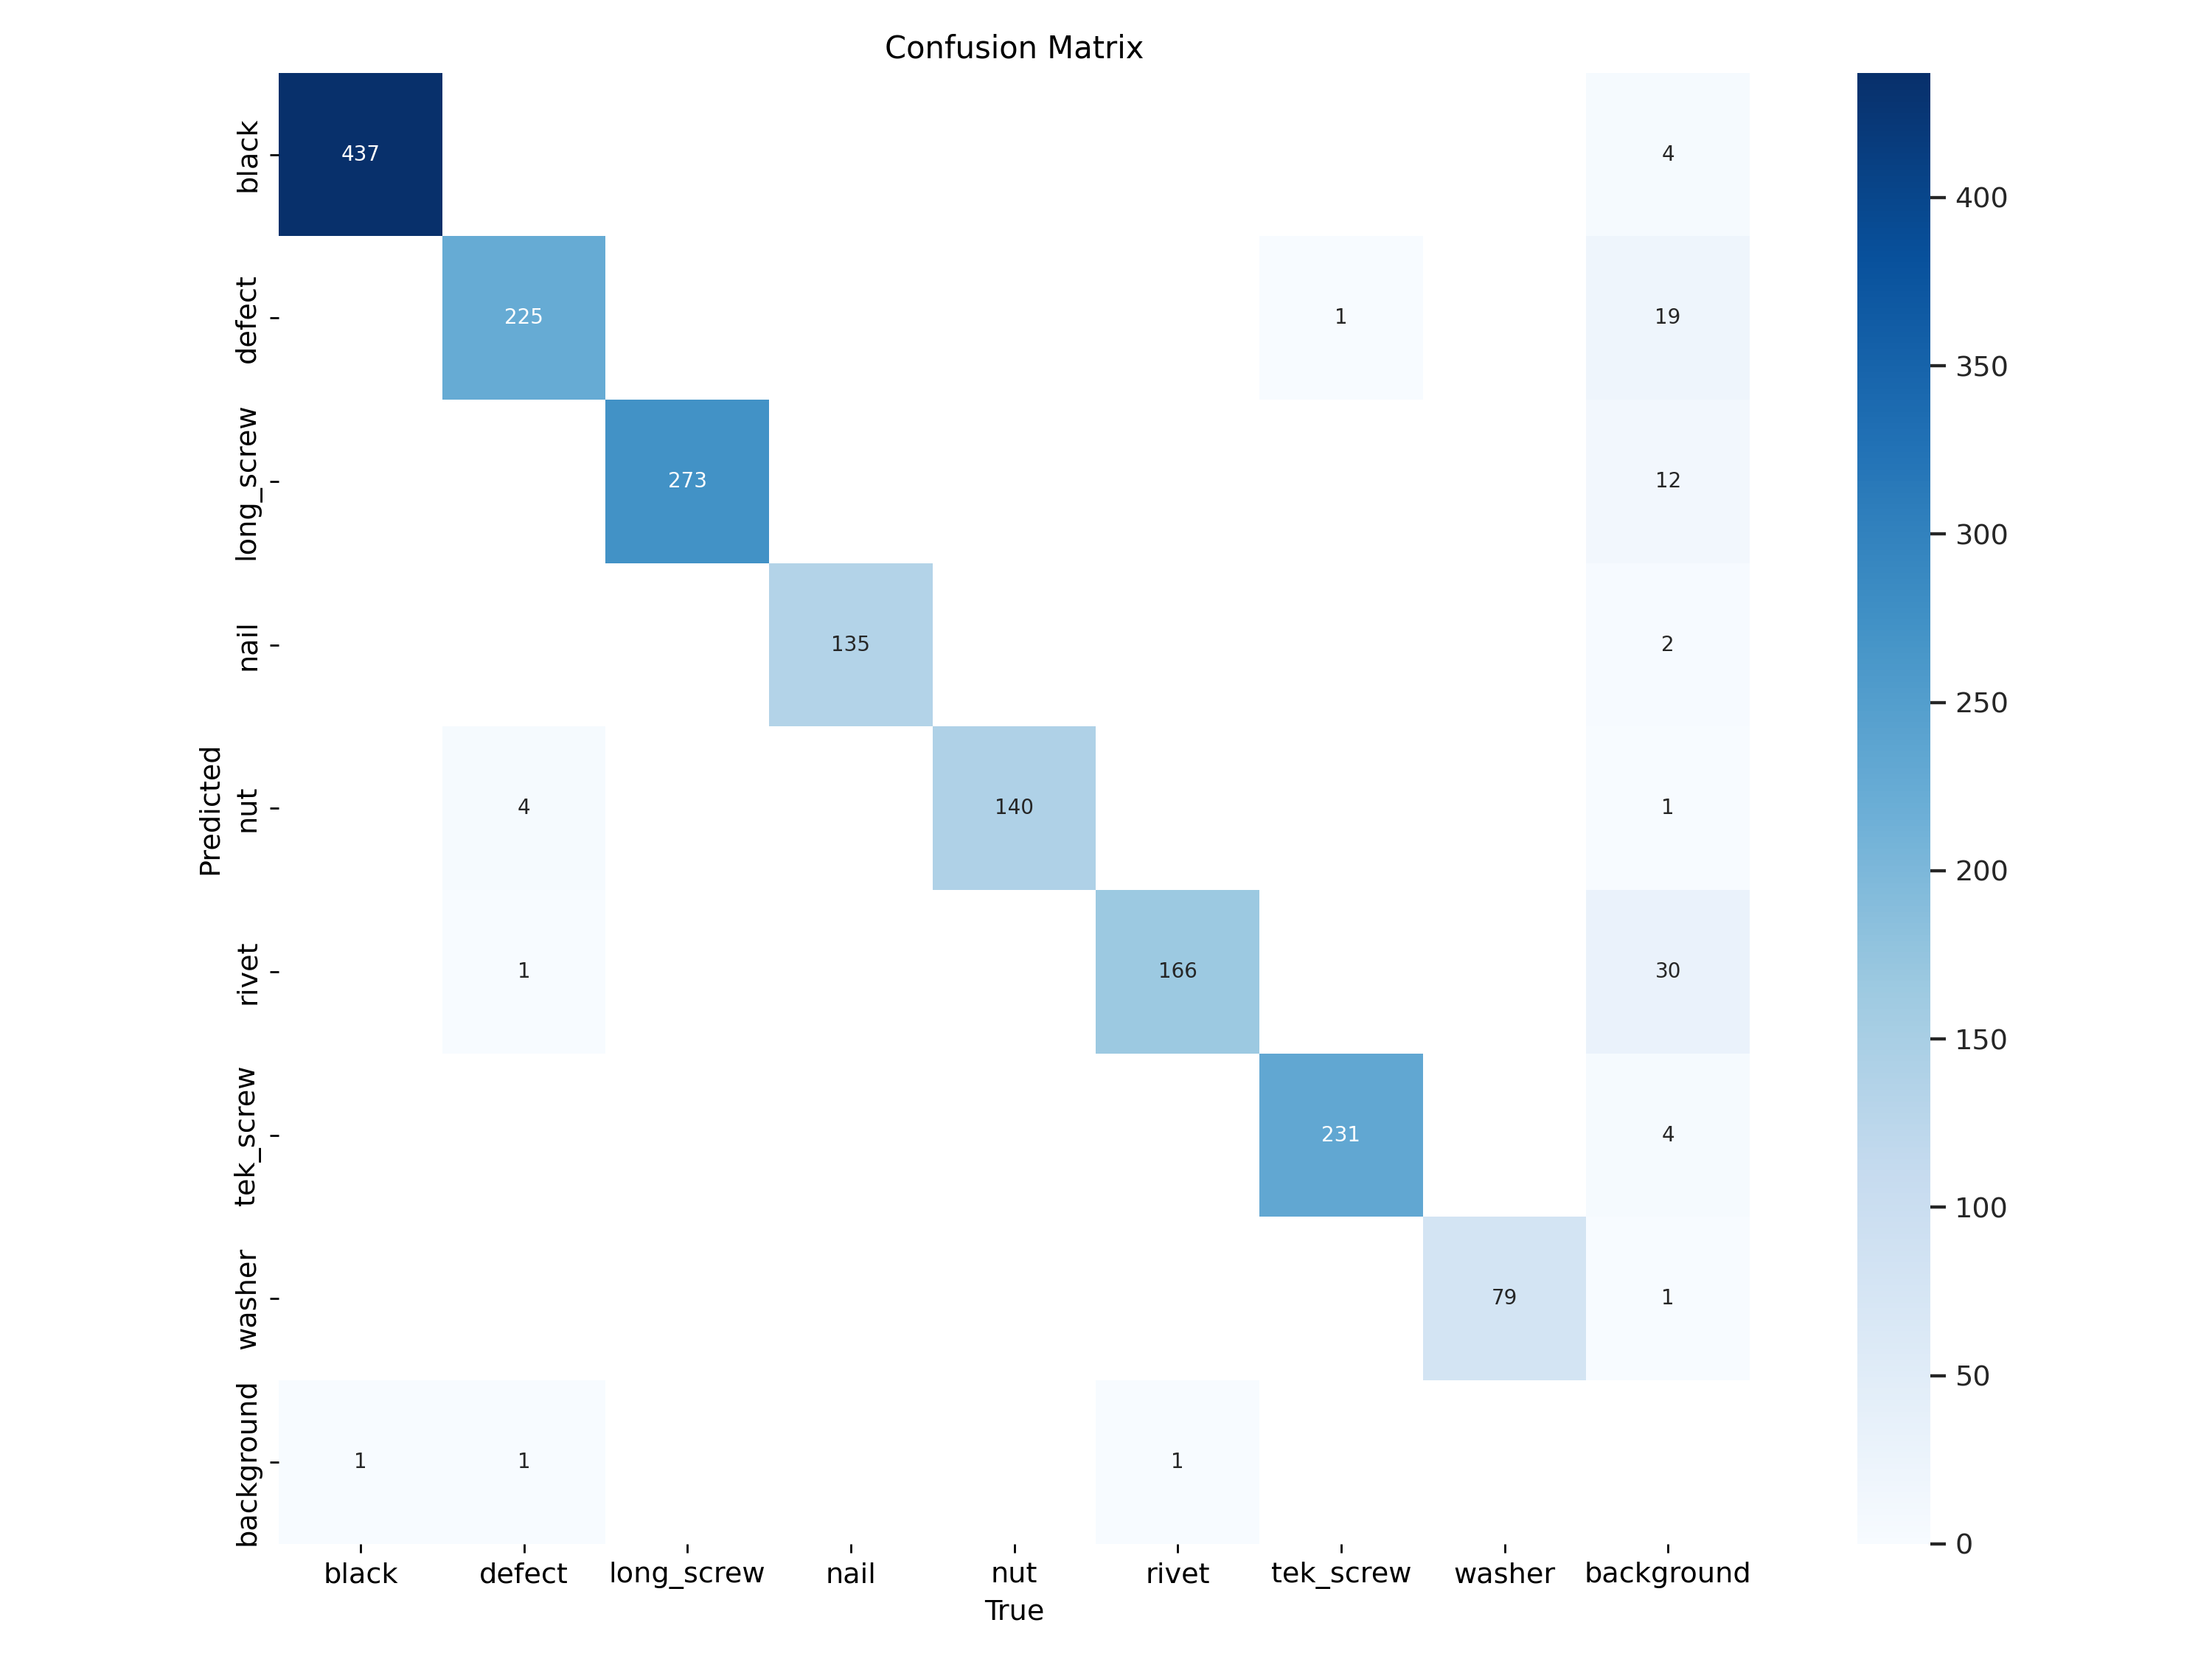


Training Results


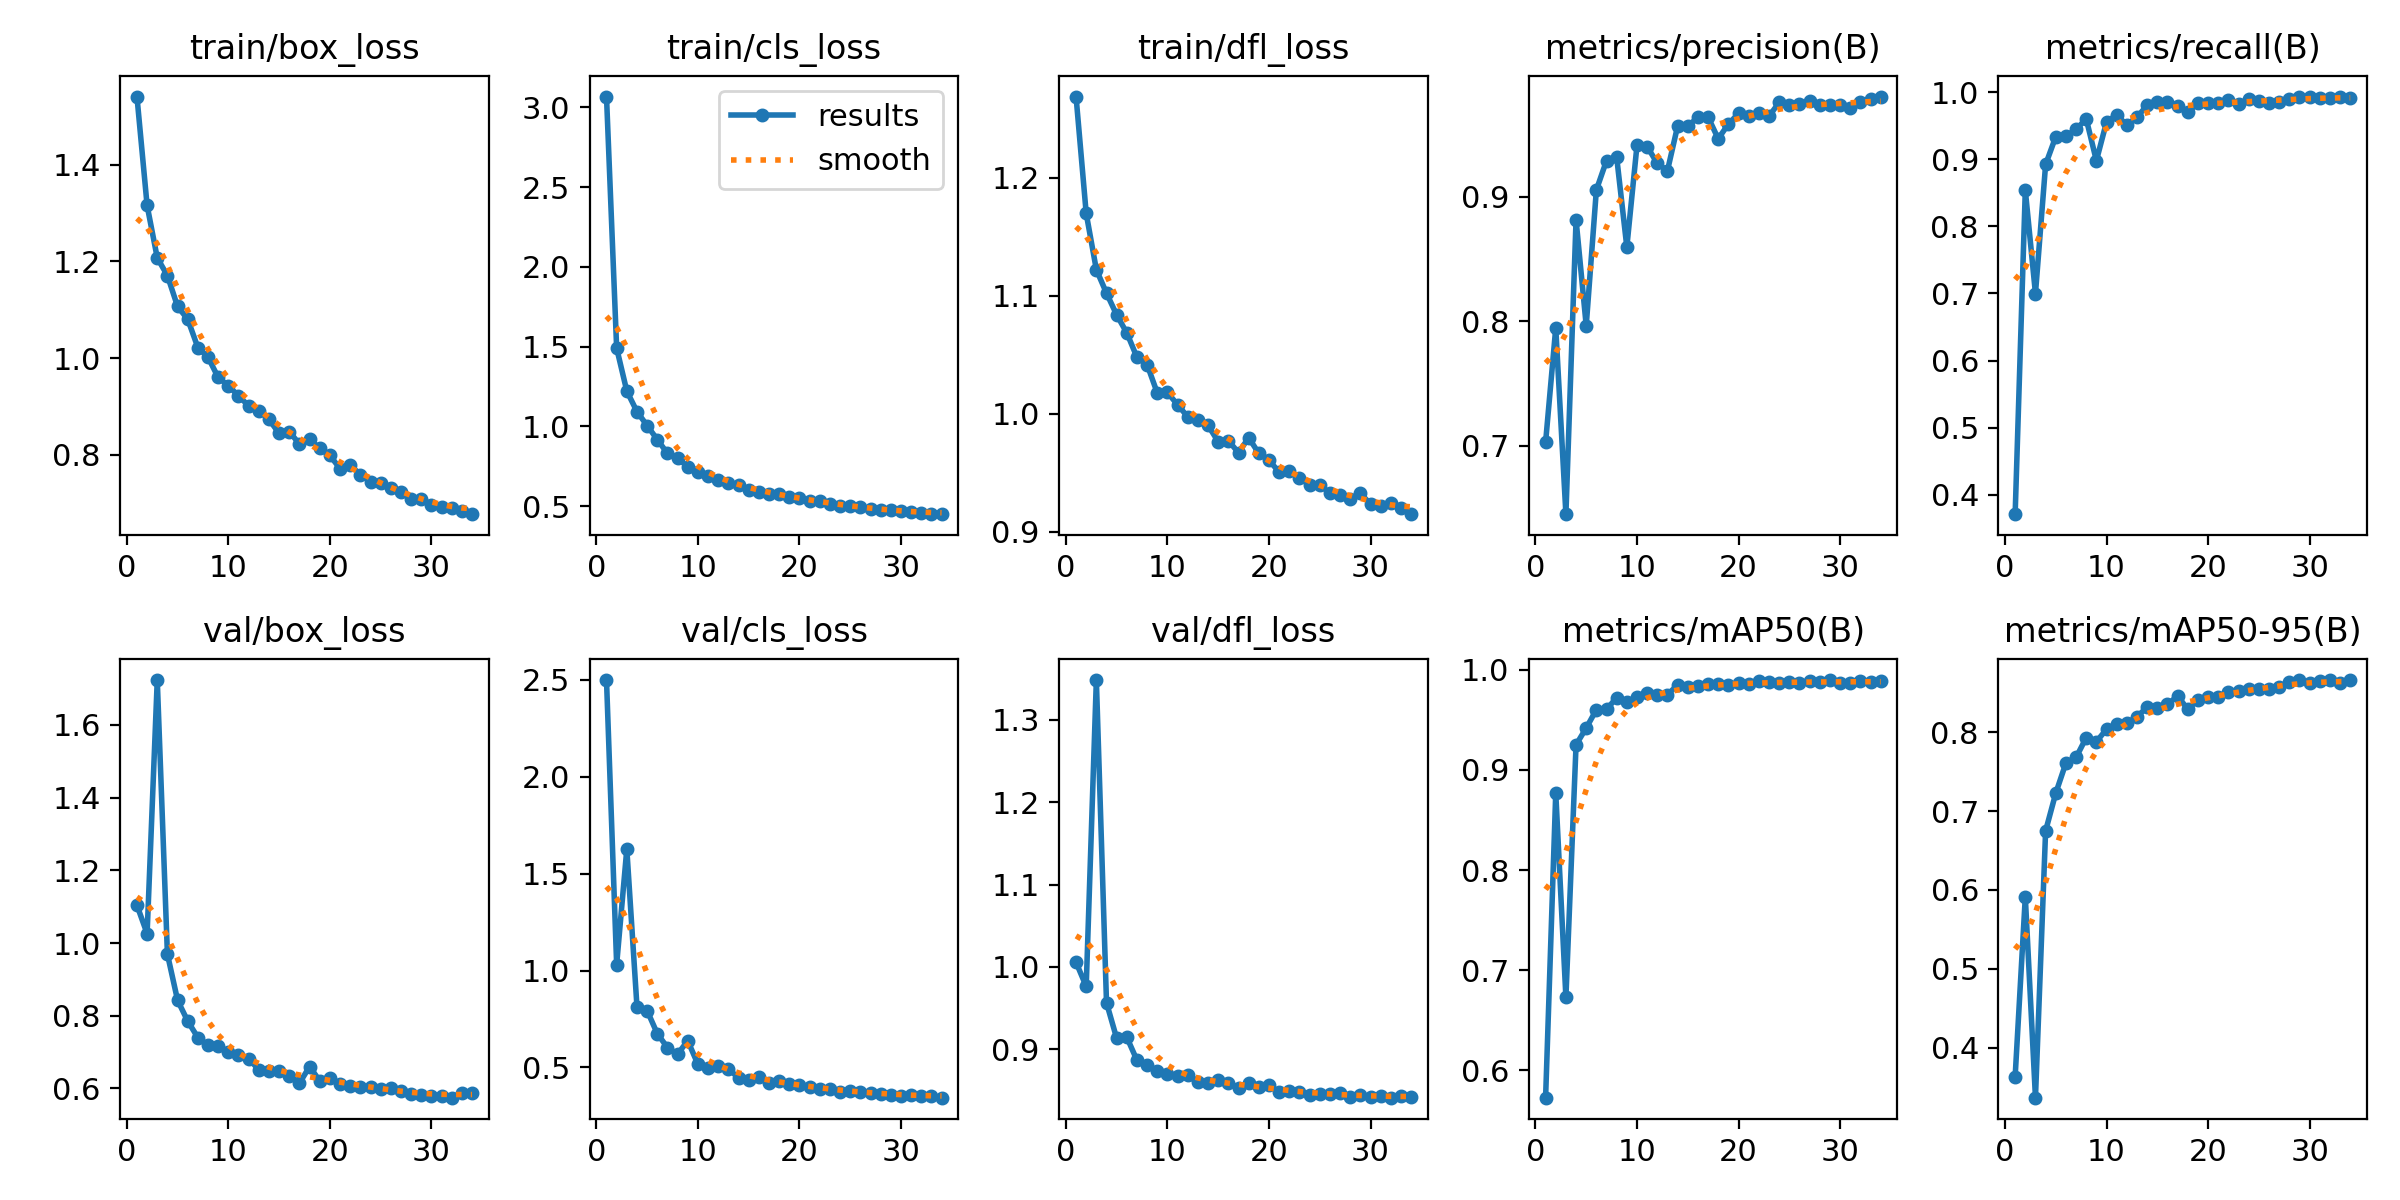


Validation Batch Predictions


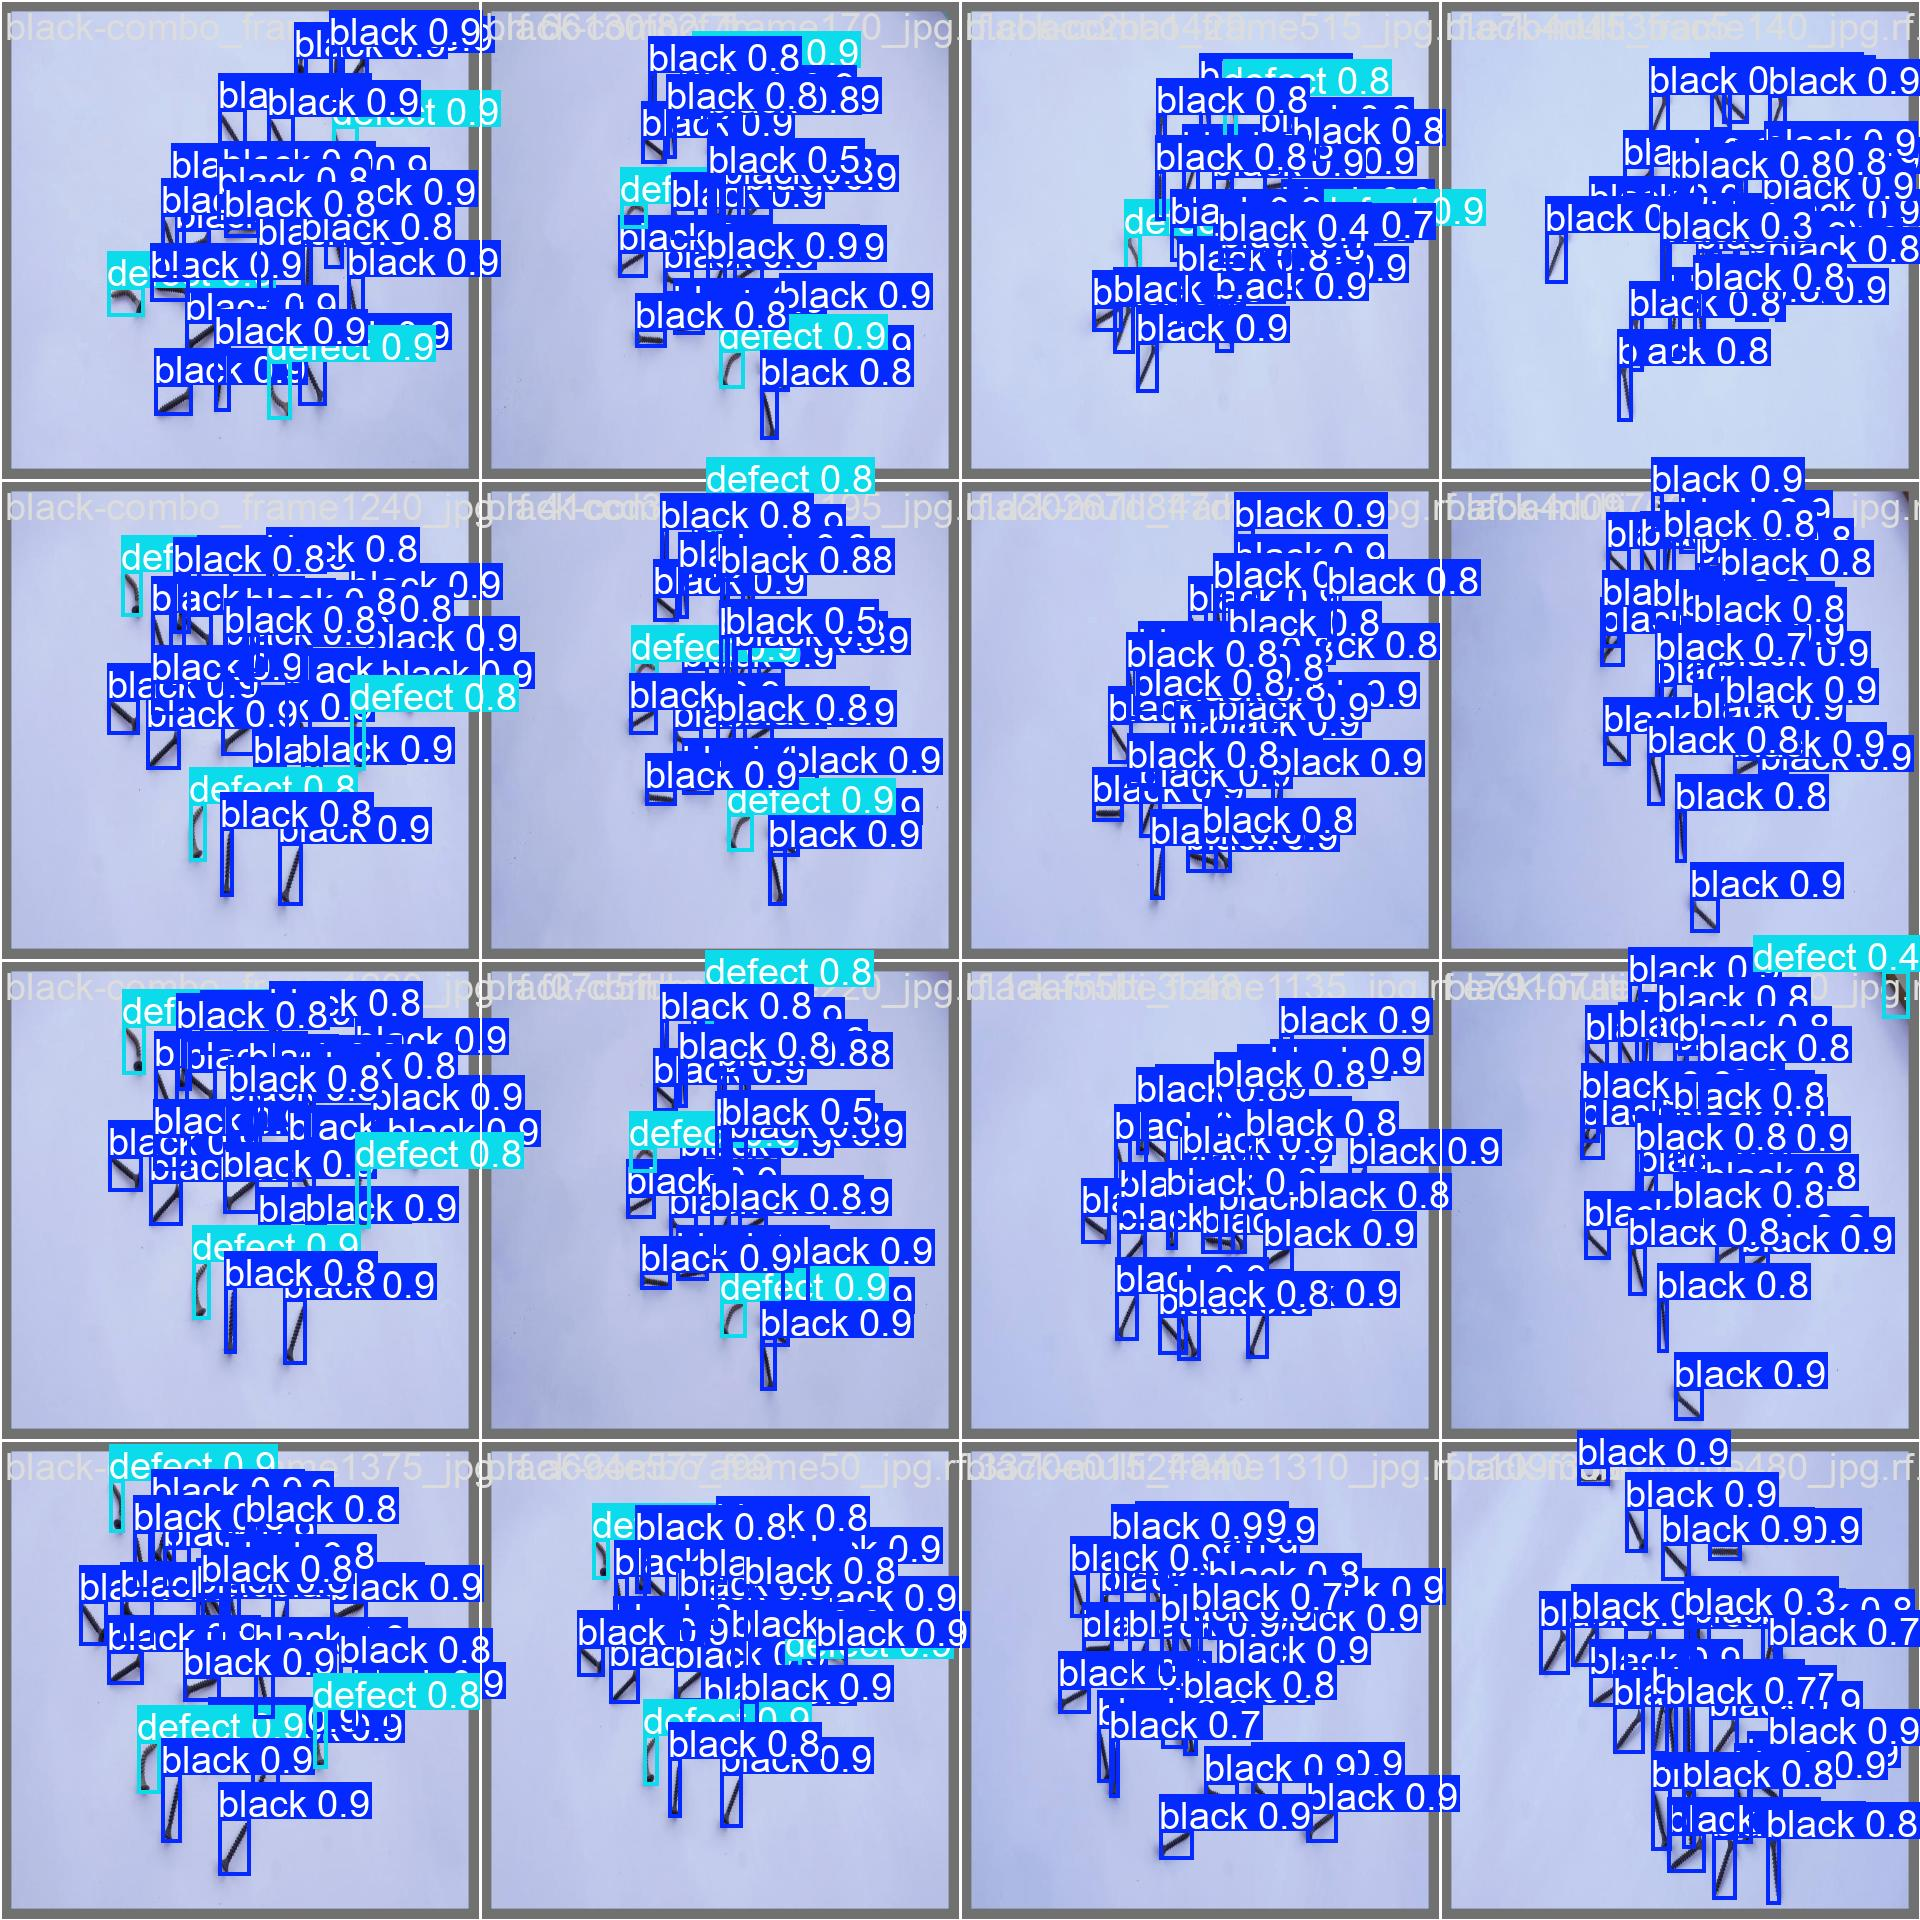

In [ ]:
# Display training results
display_training_results()

### **Model Validation**
- Validation execution
- Validation time tracking
- Metric logging

In [ ]:
# ONNX Validation Block
def validate_onnx_model():
    start_time = time.time()

    # Get model path
    latest_dir = get_latest_train_dir(HOME)
    model_path = f'{latest_dir}/weights/best.onnx'

    if os.path.exists(model_path):
        print(f"\n{'='*50}")
        print(f"VALIDATING ONNX MODEL")
        print(f"{'='*50}")
        print(f"Found ONNX model at: {model_path}")

        # Run YOLOv8 validation for ONNX
        !yolo task=detect mode=val \
            model={model_path} \
            data=/content/datasets/data.yaml

        total_time = time.time() - start_time
        print(f"ONNX validation completed in {total_time:.2f}s")
    else:
        print(f"\n{'='*50}")
        print(f"SKIPPING ONNX MODEL - NOT FOUND")
        print(f"{'='*50}")

# Call the function to validate ONNX
validate_onnx_model()


VALIDATING ONNX MODEL
Found ONNX model at: /content/runs/detect/train/weights/best.onnx
Ultralytics 8.3.122 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Loading /content/runs/detect/train/weights/best.onnx for ONNX Runtime inference...
Using ONNX Runtime CPUExecutionProvider
Setting batch=1 input of shape (1, 3, 640, 640)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 747.3±162.0 MB/s, size: 14.9 KB)
val: Scanning /content/datasets/valid/labels.cache... 121 images, 0 backgrounds, 0 corrupt: 100% 121/121 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 121/121 [00:10<00:00, 12.07it/s]
                   all        121       1695          0          0          0          0
                 black         40        438          0          0          0          0
                defect         77        231          0          0          0          0
            long_screw         29        273          0     

### **tflite model cannot see shit! Class confidence: 0.0016**
```
Running inference on image 2: set6_261_jpg.rf.82e1320363f86c6b3f4e851ea3c7c8a0.jpg
Output shape: (1, 12, 8400)
Found 10 confident detections (threshold 0.25)
Detection 1: Class 0, Confidence: 0.8986, Class confidence: 0.0016
```

In [ ]:
# TFLite Validation Block
def validate_tflite_model():
    start_time = time.time()

    # Get model path
    latest_dir = get_latest_train_dir(HOME)
    model_path = f'{latest_dir}/weights/best.tflite'

    if os.path.exists(model_path):
        print(f"\n{'='*50}")
        print(f"VALIDATING TFLITE MODEL")
        print(f"{'='*50}")
        print(f"Found TFLITE model at: {model_path}")

        try:
            import tensorflow as tf
            from PIL import Image
            import glob
            import numpy as np

            # Load the model
            print("Loading TFLite model...")
            interpreter = tf.lite.Interpreter(model_path=model_path)
            interpreter.allocate_tensors()

            # Get input and output details
            input_details = interpreter.get_input_details()
            output_details = interpreter.get_output_details()

            print(f"Input details: {input_details[0]['shape']}")
            print(f"Number of outputs: {len(output_details)}")
            for i, output in enumerate(output_details):
                print(f"Output {i+1} shape: {output['shape']}")

            # Get validation images
            val_images = glob.glob('/content/datasets/valid/images/*.jpg')[:5]

            if not val_images:
                print("No validation images found. Please check path.")
            else:
                print(f"Found {len(val_images)} validation images for testing")

                for idx, img_path in enumerate(val_images):
                    # Load and preprocess image
                    img = Image.open(img_path)
                    input_height, input_width = input_details[0]['shape'][1:3]
                    img_resized = img.resize((input_width, input_height))
                    img_array = np.array(img_resized).astype(np.float32) / 255.0
                    input_data = np.expand_dims(img_array, axis=0)

                    # Run inference
                    print(f"\nRunning inference on image {idx+1}: {os.path.basename(img_path)}")
                    interpreter.set_tensor(input_details[0]['index'], input_data)
                    interpreter.invoke()

                    # Process output
                    output_data = interpreter.get_tensor(output_details[0]['index'])
                    print(f"Output shape: {output_data.shape}")

                    # Handle YOLOv8 output format
                    if output_data.shape[1] == 12 and output_data.shape[2] == 8400:
                        # Transpose to [batch, 8400, 12] for easier processing
                        predictions = np.transpose(output_data[0], (1, 0))

                        # Apply confidence threshold (box confidence is at index 4)
                        confidence_threshold = 0.25
                        mask = predictions[:, 4] > confidence_threshold
                        filtered_predictions = predictions[mask]

                        print(f"Found {len(filtered_predictions)} confident detections (threshold {confidence_threshold})")

                        # Show top 5 detections
                        for i in range(min(5, len(filtered_predictions))):
                            box = filtered_predictions[i]
                            confidence = box[4]

                            # Get class prediction (indices 5+ are class scores)
                            class_scores = box[5:]
                            class_id = np.argmax(class_scores)
                            class_score = class_scores[class_id]

                            print(f"  Detection {i+1}: Class {class_id}, Confidence: {confidence:.4f}, Class confidence: {class_score:.4f}")

            print("\nTFLite model validation completed!")

        except Exception as e:
            print(f"Error during TFLite validation: {str(e)}")
            import traceback
            traceback.print_exc()

        total_time = time.time() - start_time
        print(f"TFLITE validation completed in {total_time:.2f}s")
    else:
        print(f"\n{'='*50}")
        print(f"SKIPPING TFLITE MODEL - NOT FOUND")
        print(f"{'='*50}")
        # List available files in the weights directory
        !ls -la {latest_dir}/weights/

# Call the function to validate TFLite
validate_tflite_model()


VALIDATING TFLITE MODEL
Found TFLITE model at: /content/runs/detect/train/weights/best.tflite
Loading TFLite model...
Input details: [  1 640 640   3]
Number of outputs: 1
Output 1 shape: [   1   12 8400]
Found 5 validation images for testing

Running inference on image 1: set6_36_jpg.rf.3612eecbbc0322b076d12efe6a0517ff.jpg
Output shape: (1, 12, 8400)
Found 0 confident detections (threshold 0.25)

Running inference on image 2: set6_261_jpg.rf.82e1320363f86c6b3f4e851ea3c7c8a0.jpg
Output shape: (1, 12, 8400)
Found 10 confident detections (threshold 0.25)
  Detection 1: Class 0, Confidence: 0.8986, Class confidence: 0.0016
  Detection 2: Class 0, Confidence: 0.8849, Class confidence: 0.0006
  Detection 3: Class 0, Confidence: 0.3102, Class confidence: 0.0004
  Detection 4: Class 0, Confidence: 0.8738, Class confidence: 0.0007
  Detection 5: Class 0, Confidence: 0.8666, Class confidence: 0.0004

Running inference on image 3: black-combo_frame1050_jpg.rf.66130f82f7bbd57a7dfe96ee4470e63e.jp

### **Prediction Generation**
- Inference on test images
- Time tracking for predictions
- Results visualization

Ultralytics 8.3.122 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Loading /content/runs/detect/train/weights/best.onnx for ONNX Runtime inference...
Using ONNX Runtime CPUExecutionProvider

image 1/52 /content/datasets/test/images/black-combo_frame1260_jpg.rf.7d9081a1b460ae46a7d350498ae5b48b.jpg: 640x640 21 blacks, 3 defects, 72.9ms
image 2/52 /content/datasets/test/images/black-combo_frame1275_jpg.rf.f22f6cdc25a2b008d87336f94c222bd3.jpg: 640x640 21 blacks, 3 defects, 69.4ms
image 3/52 /content/datasets/test/images/black-combo_frame190_jpg.rf.c513605ece9c760c242d492000796890.jpg: 640x640 21 blacks, 3 defects, 43.5ms
image 4/52 /content/datasets/test/images/black-combo_frame380_jpg.rf.84d2ae0ce629fb4dc607b0efbc8b085d.jpg: 640x640 22 blacks, 3 defects, 47.2ms
image 5/52 /content/datasets/test/images/black-combo_frame740_jpg.rf.98c067ddbb48dac01c60e882decb2a21.jpg: 640x640 21 blacks, 3 defects, 47.6ms
image 6/52 /content/datasets/test/images/black-multi_frame1220_jpg.rf.140c

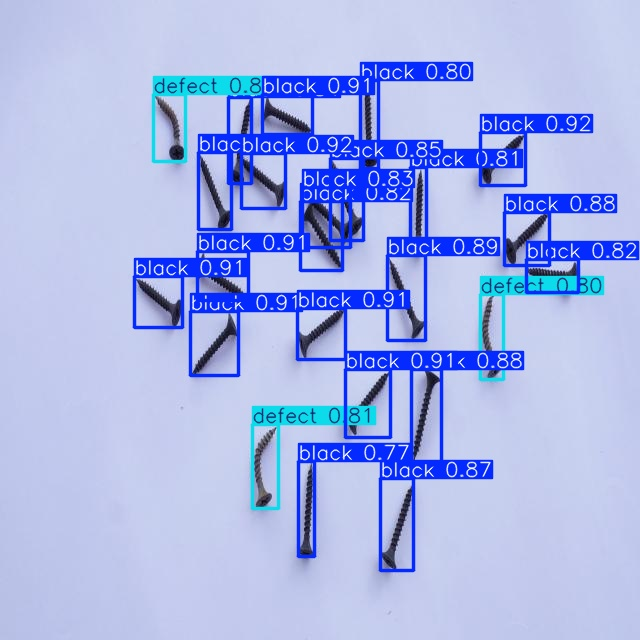

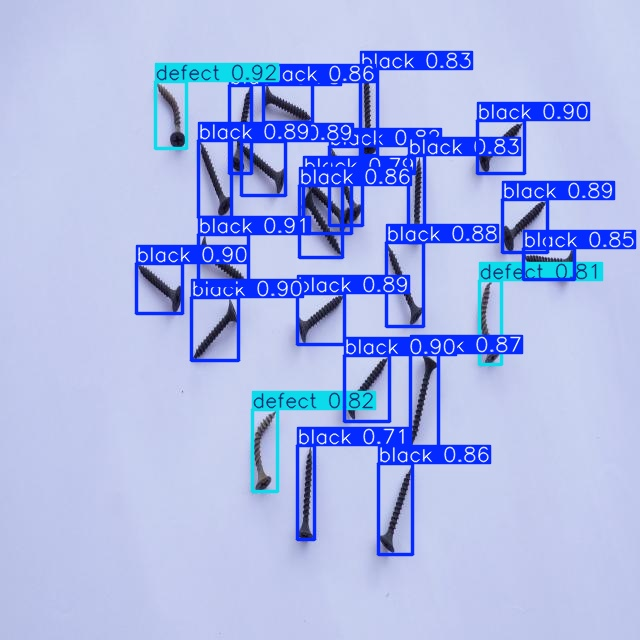

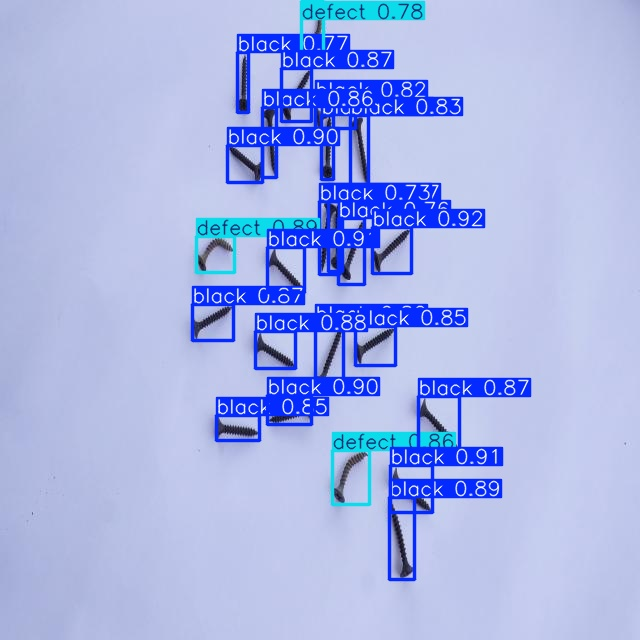

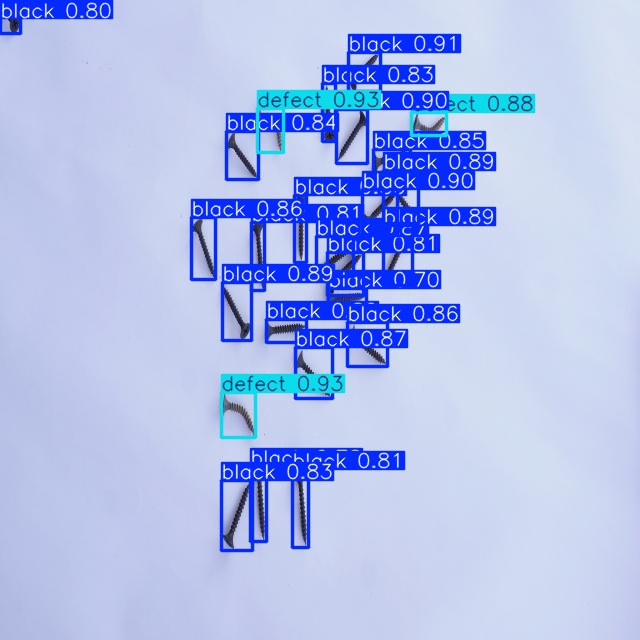

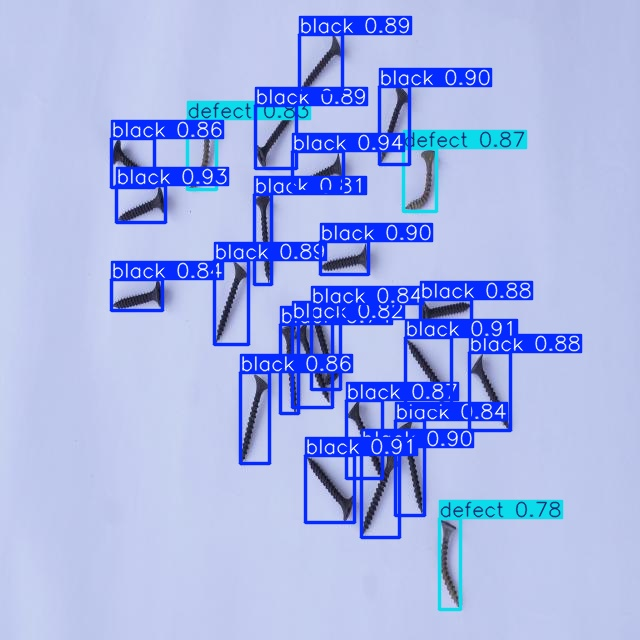



CPU times: user 65.4 ms, sys: 11.5 ms, total: 77 ms
Wall time: 8.65 s


In [ ]:
# Run predictions with MLflow
%%time
start_time = time.time()  # Record the start time for inference

# Get the latest training directory to find the model file
latest_dir = get_latest_train_dir(HOME)
model_path = f'{latest_dir}/weights/best.onnx'

# Run YOLO predictions using the command-line interface with the ONNX model
!yolo task=detect mode=predict \
    model={model_path} \
    conf={CONFIG['conf_threshold']} \
    source=/content/datasets/test/images \
    save=True

inference_time = time.time() - start_time  # Calculate the inference time
print(f'Predictions completed in {inference_time:.2f}s!')

# Display predictions for best.onnx
display_predictions(num_images=5, image_width=800)

### **THIS SHIT NEEDS FIXING!**

Loading TFLite model...
Found 52 test images
Processed roofing-nails-combo_frame145_jpg.rf.05d095d9afad34d7d29ae16805521eb7.jpg: 4 detections
Processed tek-screw-combo_frame615_jpg.rf.a2cfb3b58c63c800a434f36f7a6e5c23.jpg: 4 detections
Processed nut_frame1065_jpg.rf.1ebd515ac17c9623f484c39cfe65b3f5.jpg: 4 detections
Processed nut-combo_frame480_jpg.rf.c0bafe90731a16cdf014c1c4cd930bb3.jpg: 4 detections
Processed black-combo_frame380_jpg.rf.84d2ae0ce629fb4dc607b0efbc8b085d.jpg: 4 detections
Processed rivet_frame90_jpg.rf.7fc0e1093a7c4fa1850223c4af7a224c.jpg: 4 detections
Processed roofing-nails-combo_frame615_jpg.rf.4cea4d8337e69e022fffac4a480a17cb.jpg: 4 detections
Processed nut-combo_frame305_jpg.rf.9774dc088ffe9f551ce085936c4ccc25.jpg: 4 detections
Processed tek-screw-multi_frame1640_jpg.rf.294db785718255ccec741092fa221797.jpg: 4 detections
Processed nut_frame645_jpg.rf.120f76d4b22c2ccc959b4d2c1d510c97.jpg: 4 detections
Processed long-screw_frame315_jpg.rf.c6fcf85ba9601c3b79345f15549e2

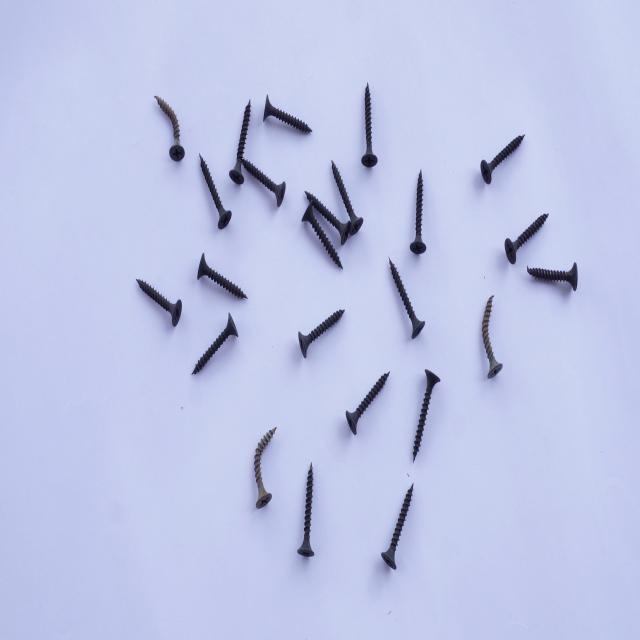

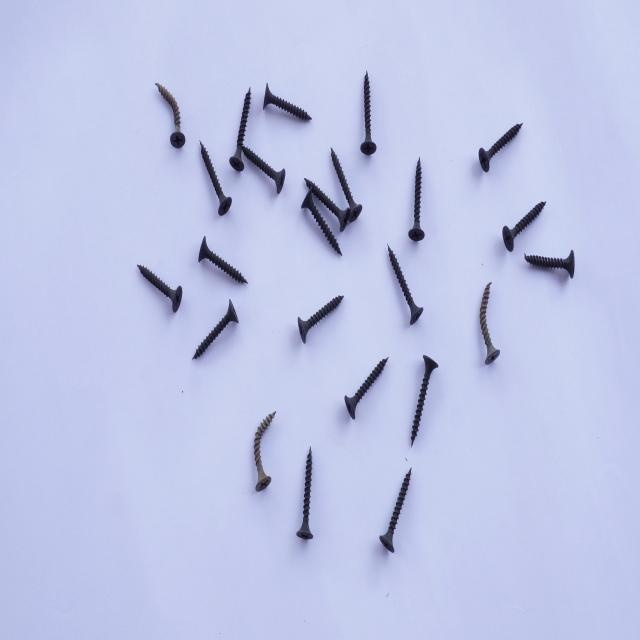

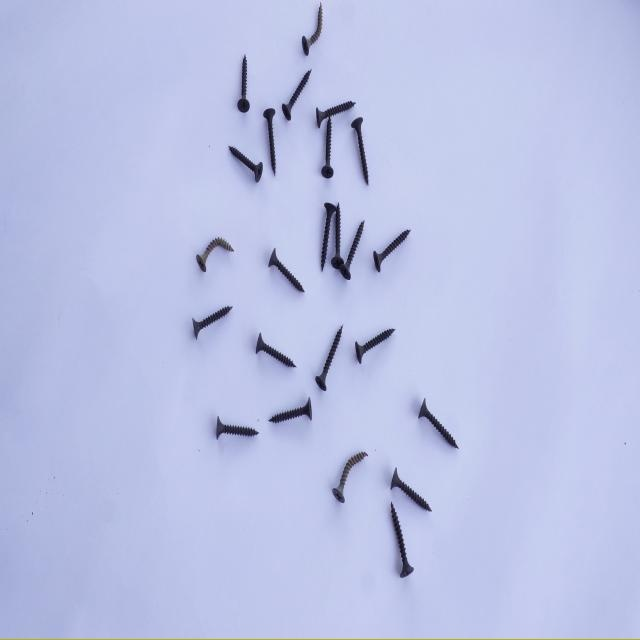

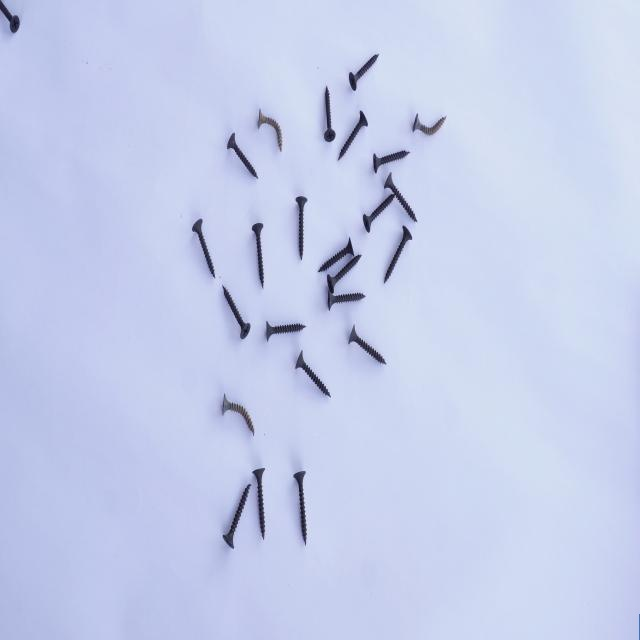

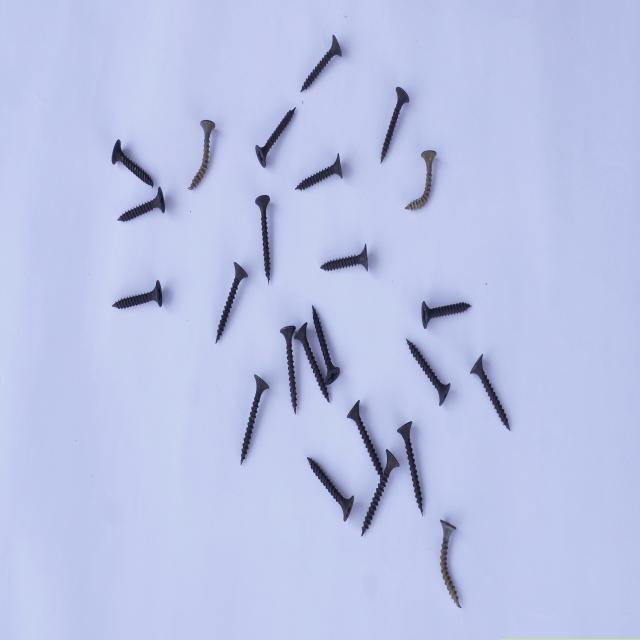



CPU times: user 3.94 s, sys: 9.79 ms, total: 3.95 s
Wall time: 3.93 s


In [ ]:
# Run TFLite predictions with MLflow
%%time
start_time = time.time()  # Record the start time for inference

# Get the latest training directory to find the model file
latest_dir = get_latest_train_dir(HOME)
model_path = f'{latest_dir}/weights/best.tflite'

# Create output directory
os.makedirs('/content/runs/detect/predict_tflite', exist_ok=True)

# Load TFLite model
print("Loading TFLite model...")
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_shape = input_details[0]['shape']
input_height, input_width = input_shape[1], input_shape[2]

# Get test images
test_images = glob.glob('/content/datasets/test/images/*.jpg') + \
              glob.glob('/content/datasets/test/images/*.jpeg') + \
              glob.glob('/content/datasets/test/images/*.png')
print(f"Found {len(test_images)} test images")

# Process each image
for img_path in test_images:
    base_name = os.path.basename(img_path)

    # Load and prepare image
    img = Image.open(img_path)
    original_width, original_height = img.size
    original_img = np.array(img)

    # Resize and preprocess for model input
    img_resized = img.resize((input_width, input_height))
    img_array = np.array(img_resized, dtype=np.float32) / 255.0
    input_data = np.expand_dims(img_array, axis=0)

    # Run inference
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    detections = interpreter.get_tensor(output_details[0]['index'])

    # Process detections and draw results
    result_img = original_img.copy()
    colors = np.random.randint(0, 255, size=(80, 3), dtype=np.uint8)
    detection_count = 0

    # Process YOLO format output [batch, num_detections, box_data]
    for i in range(detections.shape[1]):
        box_data = detections[0, i]
        confidence = box_data[4]

        if confidence >= CONFIG['conf_threshold']:
            detection_count += 1
            class_id = int(box_data[5])

            # Convert normalized coordinates to pixel values
            x_center, y_center, width, height = box_data[0:4]
            x1 = int((x_center - width/2) * original_width)
            y1 = int((y_center - height/2) * original_height)
            x2 = int((x_center + width/2) * original_width)
            y2 = int((y_center + height/2) * original_height)

            # Ensure coordinates are within image bounds
            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = min(original_width, x2), min(original_height, y2)

            # Draw bounding box and label
            color = tuple(map(int, colors[class_id % len(colors)]))
            cv2.rectangle(result_img, (x1, y1), (x2, y2), color, 2)

            label = f"Class {class_id}: {confidence:.2f}"
            cv2.putText(result_img, label, (x1, y1-5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Save result image
    output_path = f'/content/runs/detect/predict_tflite/{base_name}'
    cv2.imwrite(output_path, cv2.cvtColor(result_img, cv2.COLOR_RGB2BGR))
    print(f"Processed {base_name}: {detection_count} detections")

inference_time = time.time() - start_time  # Calculate the inference time
print(f'TFLite predictions completed in {inference_time:.2f}s!')

# Display predictions for best.tflite
display_predictions(num_images=5, image_width=800)

## **4. Model Registry and Deployment**

In [ ]:
# Register Model and Promote to Production
from mlflow.tracking import MlflowClient

def register_model_version(run_id: str, model_name: str):

    try:
        # Construct the model URI using the run ID
        model_uri = f'runs:/{run_id}/model'

        # Register the model with MLflow.
        model_details = mlflow.register_model(
            model_uri=model_uri,
            name=model_name
        )

        print(f'Model registered successfully with version: {model_details.version}')

        # Optionally, add a description to the registered model
        client = mlflow.MlflowClient()
        client.update_registered_model(
            name=model_name,
            description='YOLO-based defect detection model'
        )

        return model_details  # Return the registered model details

    except Exception as error:
        print(f'Error registering model: {str(error)}')

        return None  # Return None if registration fails

def promote_challenger_to_production(model_name: str, prod_name: str):

    try:
        client = MlflowClient()  # Create an MLflow client

        # Construct the URI for the challenger model
        current_model_uri = f"models:/{model_name}@challenger"

        # Copy the challenger model version to the production model name.
        production_model = client.copy_model_version(
            src_model_uri=current_model_uri,
            dst_name=prod_name
        )

        print(f'Successfully promoted challenger to Production as {prod_name}')

        return production_model  # Return the production model details

    except Exception as error:
        print(f'Error promoting model: {str(error)}')

        return None  # Return None if promotion fails

# Register Model Operation
def register_model_operation(run_id: str, config: dict):

    model_name = generate_model_name(config)  # Generate the model name using the config

    model_details = register_model_version(run_id, model_name)  # Register the model version

    if model_details:  # Check if registration was successful
        print('\nModel Registration Details:')
        print(f'Name: {model_details.name}')
        print(f'Version: {model_details.version}')
        print(f'Stage: {model_details.status}')

        return model_details  # Return the model details if registration was successful

    return None  # Return None if registration failed

# Promote Challenger Model
def promote_challenger_operation(model_name: str, prod_name: str = 'defect-detection-production'):

    production_model = promote_challenger_to_production(model_name, prod_name)  # Promote the model

    if production_model:  # Check if promotion was successful
        print(f'\nProduction Model Details:')
        print(f'Name: {production_model.name}')
        print(f'Version: {production_model.version}')

        return production_model  # Return the production model details if promotion was successful

    return None  # Return None if promotion failed

### **Model Registration**
- `register_model_version()`: Registers model in MLflow
- `register_model_operation()`: Handles model registration workflow
- To get the "run_id"
  - go to https://dagshub.com/erwincarlogonzales/defect-detection-yolov11.mlflow
  - defect-detection-yolov11s-android
  - select model from Run Name
  - copy Run ID

In [ ]:
# Register Model
model_details = register_model_operation(run_id, CONFIG)  # Register the model using the run ID and configuration

### **Production Deployment**
- `promote_challenger_to_production()`: Promotes model to production
- `promote_challenger_operation()`: Manages promotion workflow
- To label a model `challenger`
  - go to https://dagshub.com/erwincarlogonzales/defect-detection-yolov11.mlflow
  - defect-detection-yolov11s-android
  - select model from Run Name
  - Models
  - yolo11s-40-50 (version 4)
  - edit "Aliases" to `challenger`

In [ ]:
# Promotion (after setting challenger alias in UI)
if model_details:  # Proceed with promotion only if model registration was successful
    prod_name = 'object-detection-YOLOv11n-edge-production'  # Define the desired name for the production model
    production_model = promote_challenger_operation(model_details.name, prod_name)  # Promote the challenger model to production

## **5. Summary of Results**